<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/utk_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTK Face Detection

## Description of dataset
https://www.kaggle.com/datasets/jangedoo/utkface-new?select=crop_part1
UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

https://susanqq.github.io/UTKFace/

## Notebook Preparation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git
!pip install -q kaggle
from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.6 MB/s eta 0:00:00


## Downloading Kaggle Dataset

In [2]:
import shutil
from google.colab import files
files.upload() # upload kaggle.json
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jangedoo/utkface-new
!unzip -qq utkface-new.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 69 Jun 30 07:38 kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 96% 319M/331M [00:01<00:00, 189MB/s]
100% 331M/331M [00:01<00:00, 175MB/s]


In [3]:
# Prepare DF for data
from pathlib import Path

data_dir = Path('UTKFace')
data_paths = list(data_dir.rglob('*.jpg'))

# UTKFace file is organised as [age]_[gender]_[race]_[date&time].jpg
def get_limiter(path, limiter):
  return [pos for pos, char in enumerate(path.name) if char == limiter]

def get_df(paths):
  path_dict={'path': [],
             'age': [],
             'gender': [],
             'race': []}
  for path in paths:
    limiters = get_limiter(path, '_')
    if len(limiters) == 3:
      path_dict['path'].append(str(path))
      path_dict['age'].append(min(float(path.name[:limiters[0]]),100))
      path_dict['gender'].append(float(path.name[limiters[0]+1:limiters[1]]))
      path_dict['race'].append(float(path.name[limiters[1]+1:limiters[2]]))

  return pd.DataFrame(path_dict)

# Using paths values to put into dataframe
df_uktface = get_df(data_paths)

df_uktface.describe(), df_uktface.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   path    23705 non-null  object 
 1   age     23705 non-null  float64
 2   gender  23705 non-null  float64
 3   race    23705 non-null  float64
dtypes: float64(3), object(1)
memory usage: 740.9+ KB


(                age        gender          race
 count  23705.000000  23705.000000  23705.000000
 mean      33.292470      0.477283      1.269226
 std       19.854777      0.499494      1.345638
 min        1.000000      0.000000      0.000000
 25%       23.000000      0.000000      0.000000
 50%       29.000000      0.000000      1.000000
 75%       45.000000      1.000000      2.000000
 max      100.000000      1.000000      4.000000,
 None)

## Check distribution of dataset

In [4]:
# Apply train test split in dataframe
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df_uktface, test_size=0.2)

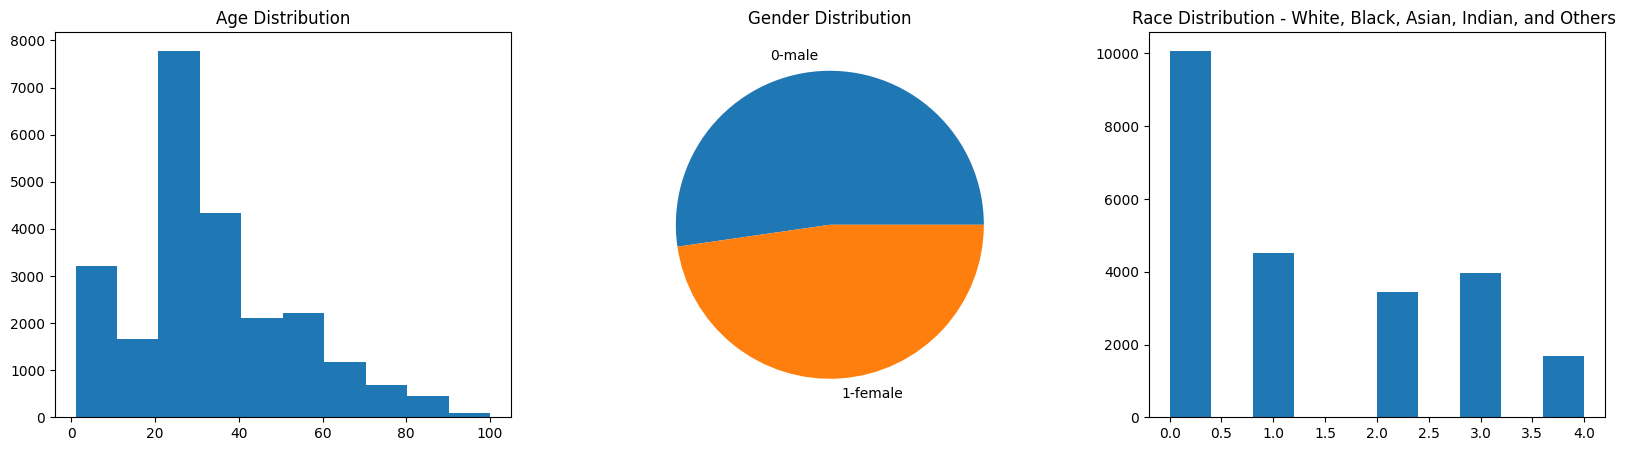

In [5]:
# Check distribution of full data
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.hist(df_uktface['age'])
plt.title('Age Distribution')
plt.subplot(1,3,2)
plt.pie(df_uktface['gender'].value_counts(), labels=['0-male', '1-female'])
plt.title('Gender Distribution')
plt.subplot(1,3,3)
plt.hist(df_uktface['race'])
plt.title('Race Distribution - White, Black, Asian, Indian, and Others ');

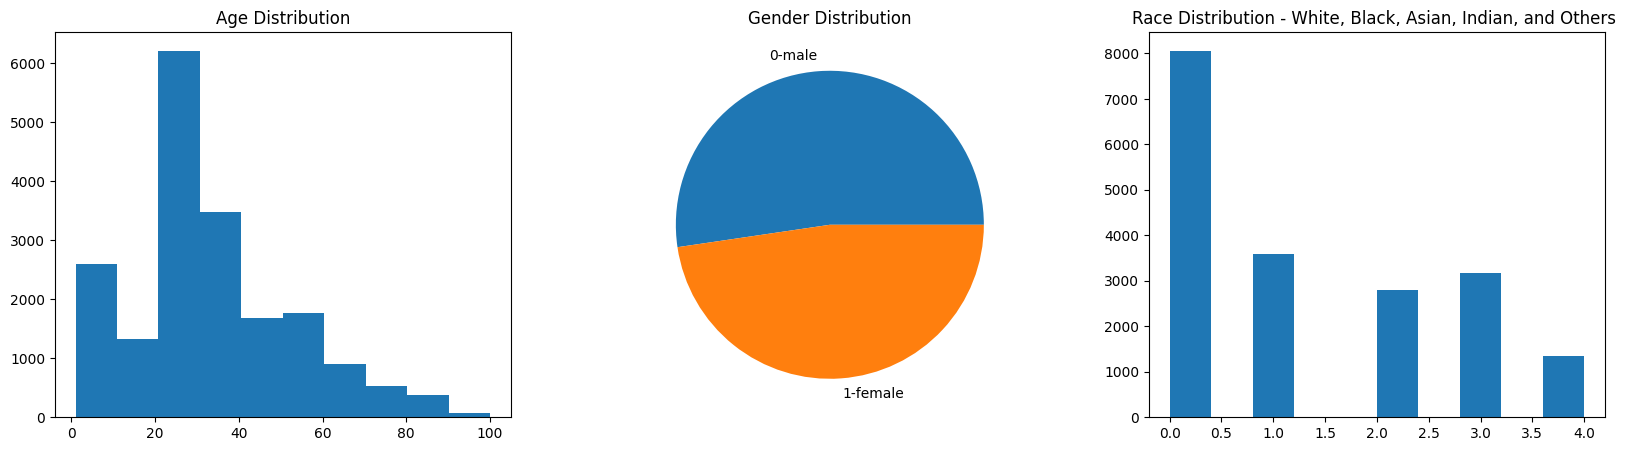

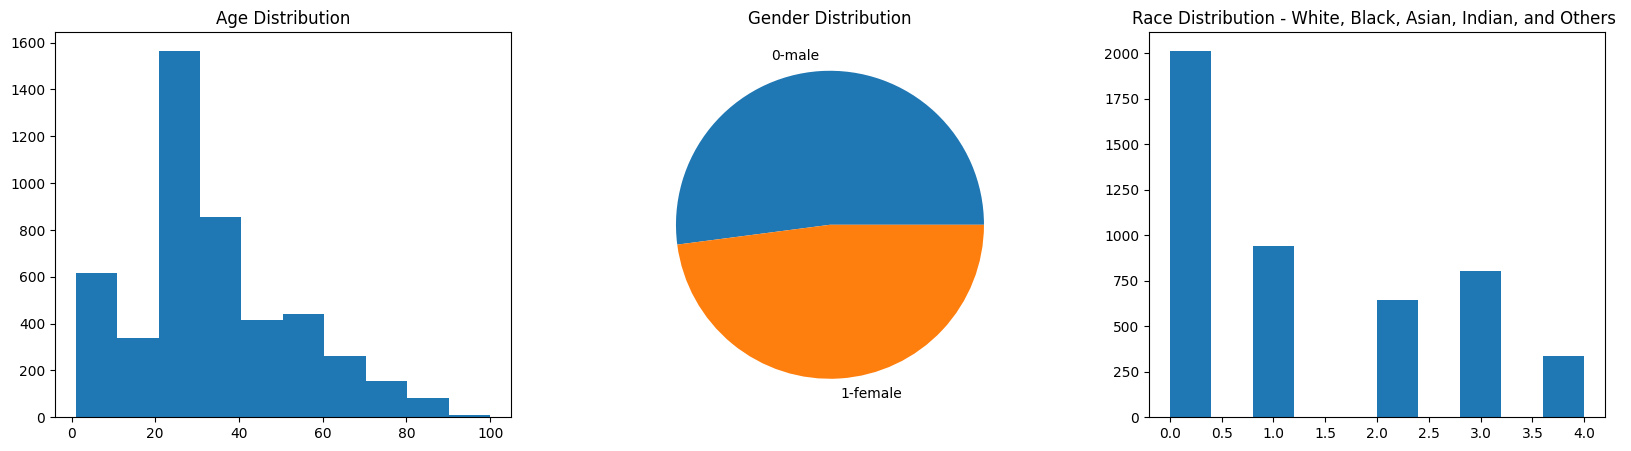

In [6]:
# Check of train data
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.hist(df_train['age'])
plt.title('Age Distribution')
plt.subplot(1,3,2)
plt.pie(df_train['gender'].value_counts(), labels=['0-male', '1-female'])
plt.title('Gender Distribution')
plt.subplot(1,3,3)
plt.hist(df_train['race'])
plt.title('Race Distribution - White, Black, Asian, Indian, and Others ');

# Check of valid data
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.hist(df_valid['age'])
plt.title('Age Distribution')
plt.subplot(1,3,2)
plt.pie(df_valid['gender'].value_counts(), labels=['0-male', '1-female'])
plt.title('Gender Distribution')
plt.subplot(1,3,3)
plt.hist(df_valid['race'])
plt.title('Race Distribution - White, Black, Asian, Indian, and Others ');

## Prepare dataset and dataloaders with pretrained_transformation

In [7]:
from torchvision.transforms import v2 as T

# Get Resnet50 pretrained weights
weights = torchvision.models.get_weight("ResNet50_Weights.IMAGENET1K_V2")

# image transform for dataset
tfms = weights.transforms()

rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std = list(map(lambda x: 1/x, tfms.std))),
    T.Normalize(mean=list(map(lambda x: -x, tfms.mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

In [8]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class AGRDataset(Dataset):
  def __init__(self, df, tfms):
    self.df = df
    self.tfms = tfms
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    img = self.tfms(Image.open(self.df.iloc[idx].path))
    age = torch.tensor(self.df.iloc[idx].age/100, dtype=torch.float32)
    gender = torch.tensor(self.df.iloc[idx].gender, dtype=torch.float32)
    race = torch.tensor(self.df.iloc[idx].race, dtype=torch.int64)
    return img, {'age': age, 'gender': gender, 'race': race}

In [9]:
train_ds = AGRDataset(df=df_train,
                      tfms=tfms)
valid_ds = AGRDataset(df=df_valid,
                      tfms=tfms)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=32,
                      shuffle=True,
                      pin_memory=True,
                      drop_last=True)
valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=32,
                      shuffle=False,
                      pin_memory=True,
                      drop_last=True)

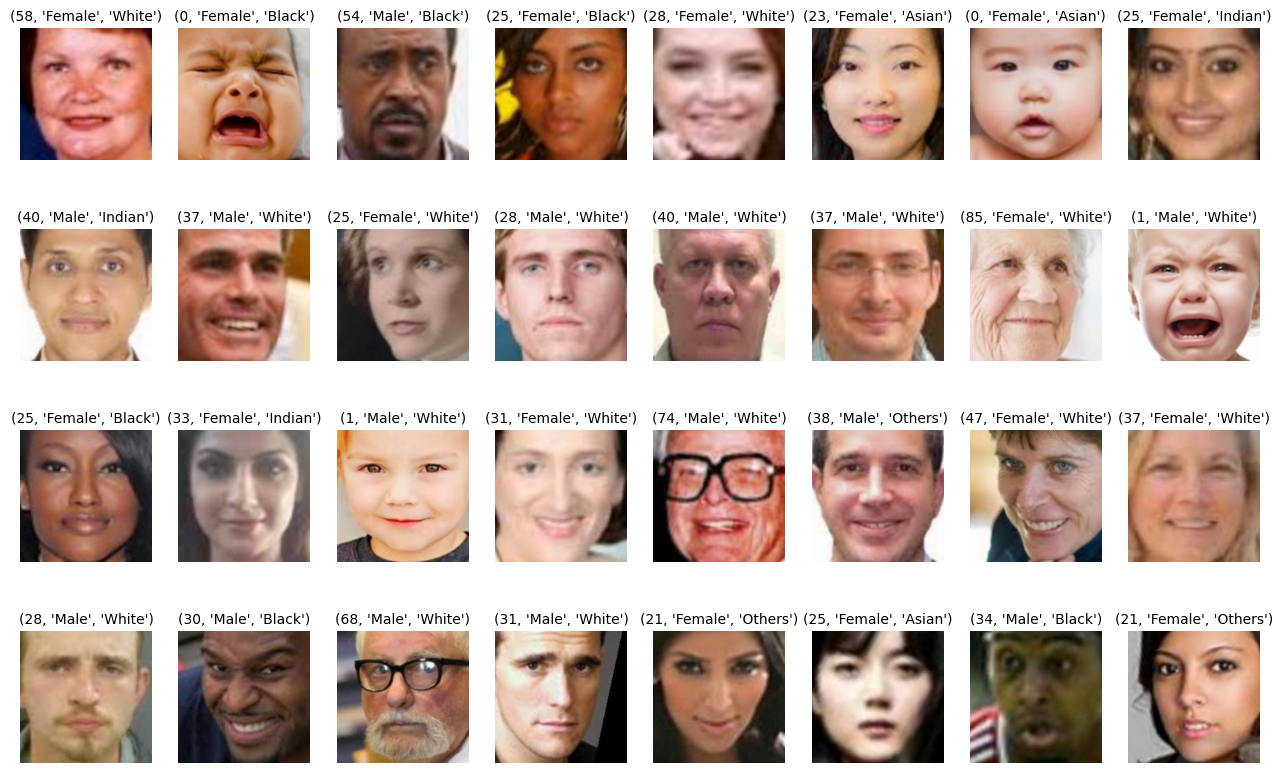

In [10]:
gender_class = ['Male', 'Female']
race_class = ['White', 'Black', 'Asian', 'Indian', 'Others']

images, labels = next(iter(train_dl))

fig = plt.figure(figsize=(16, 10))
rows, columns = 4, 8
for i in range(len(labels['age'])):
    plt.subplot(rows, columns, i+1)
    plt.imshow(rtfms(images[i]))
    age = int(labels['age'][i].item()*100)
    gender = gender_class[int(labels['gender'][i].item())]
    race = race_class[int(labels['race'][i].item())]
    plt.title((age, gender, race), fontsize=10)
    plt.axis(False)

## Using Pre-trained model Resnet50 for Transfer Learning

In [11]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


## Replacing fc with custom classifier

In [12]:
import torch.nn as nn

class AGRClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate = nn.Sequential(nn.Linear(2048, 512),
                                          nn.ReLU(),
                                          nn.BatchNorm1d(512),
                                          nn.Dropout(0.4),
                                          nn.Linear(512, 128),
                                          nn.ReLU(),
                                          nn.BatchNorm1d(128),
                                          nn.Dropout(0.4),
                                          nn.Linear(128, 64),
                                          nn.ReLU())
        self.age_classifier = nn.Sequential(nn.Linear(64, 1),
                                            nn.Sigmoid())
        self.gender_classifier = nn.Sequential(nn.Linear(64, 1),
                                               nn.Sigmoid())
        self.race_classifier = nn.Sequential(nn.Linear(64, 5),
                                             nn.LogSoftmax(dim=1))

    def forward(self, X):
        X = self.intermediate(X)
        age = self.age_classifier(X).squeeze()
        gender = self.gender_classifier(X).squeeze()
        race = self.race_classifier(X).squeeze()
        return {'age': age,
                'gender': gender,
                'race': race}

In [13]:
model.fc = AGRClassifier()

In [18]:
# Developing loss_fn vs metric_fn

class AGRLossFn:
  def __init__(self):
    self.age_loss = nn.SmoothL1Loss()
    self.gender_loss = nn.BCELoss()
    self.race_loss = nn.NLLLoss()
  def __call__(self, y_logits, y):
    age_loss = self.age_loss(y_logits['age'], y['age'])
    gender_loss = self.gender_loss(y_logits['gender'], y['gender'])
    race_loss = self.race_loss(y_logits['race'], y['race'])
    return  10*age_loss + gender_loss + race_loss

loss_fn = AGRLossFn()

class AGRMetricFn:
  def __init__(self):
    self.age_metric = nn.L1Loss()
  def __call__(self, y_logits, y):
    age_metric = self.age_metric(y_logits['age'], y['age']).item()*100
    gender_metric = (y_logits['gender'].round() == y['gender']).sum().item() / len(y['gender'])
    race_metric = (y_logits['race'].argmax(dim=1) == y['race']).sum().item() / len(y['race'])
    return {'age_mae': age_metric, 'gender_acc': gender_metric, 'race_acc': race_metric}

metric_fn = AGRMetricFn()

# Define optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

# Initialise SSTLearner Class
learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

In [19]:
learner.freeze()
learner.unfreeze(['fc'])

In [20]:
learner.model_info()

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                               [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Conv2d (conv1)                              [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                           [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                                 [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                         [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)                    [32, 64, 56, 56]     [32, 64, 56, 

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 3.98E-03 | Lowest Loss: 1.91E-02


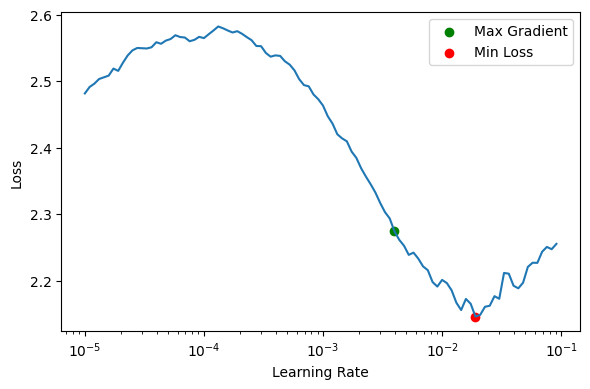

In [17]:
learner.lr_range_test(end_lr=1e-1, start_lr=1e-5)

In [21]:
learner.train(20)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-03 | train_loss: 1.739 | valid_loss: 1.528 
train_metric: {'age_mae': 11.93, 'gender_acc': 0.754, 'race_acc': 0.574}
valid_metric: {'age_mae': 10.597, 'gender_acc': 0.807, 'race_acc': 0.63}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-03 | train_loss: 1.53 | valid_loss: 1.467 
train_metric: {'age_mae': 10.919, 'gender_acc': 0.793, 'race_acc': 0.629}
valid_metric: {'age_mae': 10.125, 'gender_acc': 0.823, 'race_acc': 0.633}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-03 | train_loss: 1.457 | valid_loss: 1.427 
train_metric: {'age_mae': 10.465, 'gender_acc': 0.805, 'race_acc': 0.651}
valid_metric: {'age_mae': 9.836, 'gender_acc': 0.824, 'race_acc': 0.657}
----------------------------------------------------------------------------------------------------
Epoch: 4 | LR: 1.0E-03 | train_loss: 1.422 | valid_loss: 1.431 
t

# Making Predictions

In [22]:
# Make prediction of the valid_dataset
age = {'preds':[], 'labels': []}
gender = {'preds':[], 'labels': []}
race = {'preds':[], 'labels': []}

with torch.inference_mode():
    for batch, (X, y) in enumerate(valid_dl):
        X = X.to('cuda')
        y_logits = learner.model(X)
        age['preds'] += y_logits['age'].tolist()
        age['labels'] += y['age'].tolist()
        gender['preds'] += y_logits['gender'].tolist()
        gender['labels'] += y['gender'].tolist()
        race['preds'] += y_logits['race'].argmax(dim=1).tolist()
        race['labels'] += y['race'].tolist()

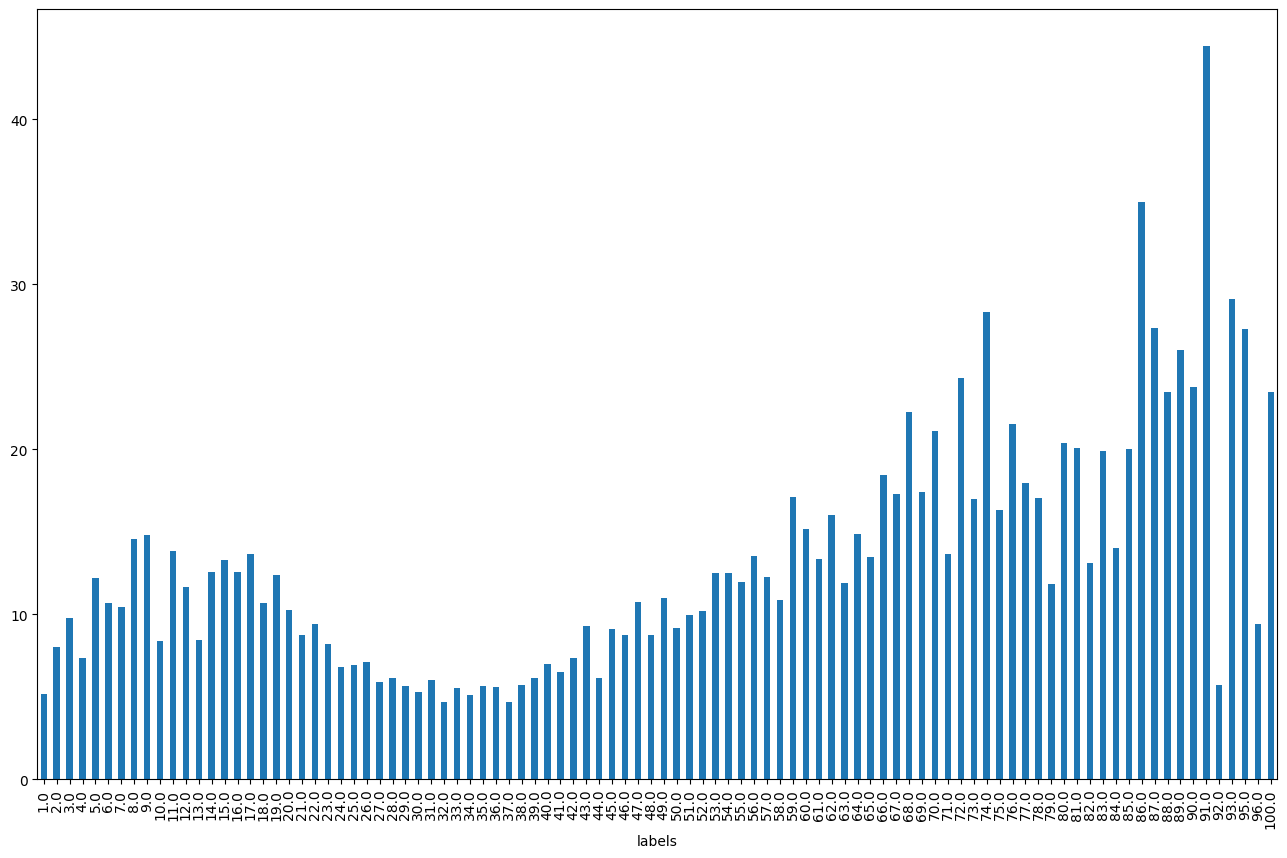

In [23]:
## Statistics of Age prediction
df_age = pd.DataFrame(age)*100
df_age['labels'] = df_age['labels'].round(0)
df_age['abs_diff'] = (df_age['preds'] - df_age['labels']).abs()
df_age.groupby('labels').mean()['abs_diff'].plot.bar(figsize=(16, 10));

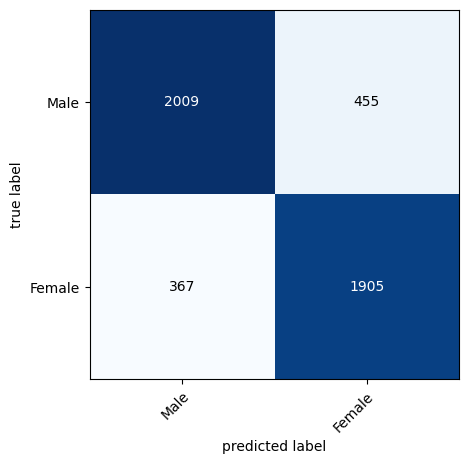

In [24]:
# Confusion matrix for gender prediction
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_gender = pd.DataFrame(gender)
df_gender['preds_results'] = df_gender['preds'].round(0)

cm = confusion_matrix(y_target=df_gender['labels'],
                      y_predicted=df_gender['preds_results'])
gender_class = ['Male', 'Female']
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=gender_class)

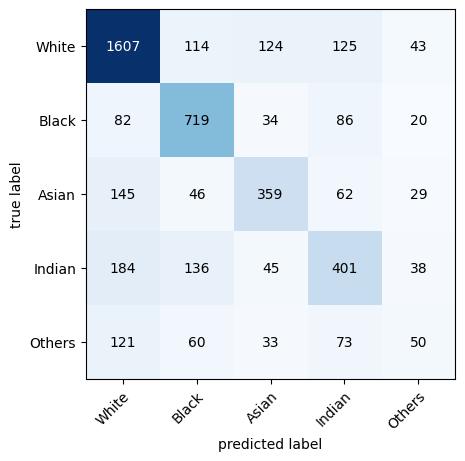

In [25]:
# Confusion matrix for gender prediction
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_race = pd.DataFrame(race)

cm = confusion_matrix(y_target=df_race['labels'],
                      y_predicted=df_race['preds'])
race_class = ['White', 'Black', 'Asian', 'Indian', 'Others']
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=race_class)

Age: 81 | Gender: Male | Race: White


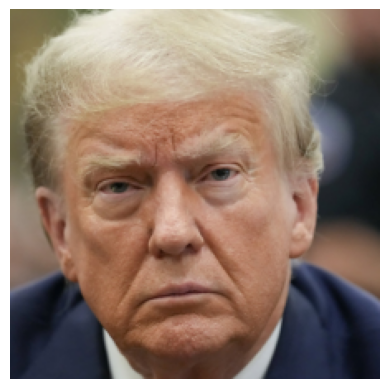

In [33]:
# Download photo
import requests

image_url = 'https://s7d2.scene7.com/is/image/TWCNews/AP_Trump_Fraud_Trial_Day2_100323?wid=1250&hei=703&$wide-bg$'

img = Image.open(requests.get(url=image_url, stream=True).raw).convert('RGB')

with torch.inference_mode():
    labels = learner.model(tfms(img).unsqueeze(dim=0).to('cuda'))
    print(f"Age: {int(labels['age'].item()*100)} | Gender: {gender_class[int(labels['gender'].item())]} | Race: {race_class[labels['race'].argmax(dim=0).item()]}")
    plt.imshow(rtfms(tfms(img)))
    plt.axis(False)

Age: 35 | Gender: Male | Race: Asian


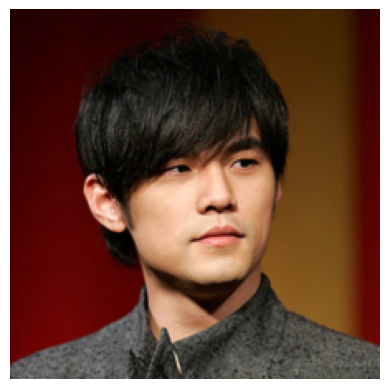

In [39]:
# Download photo
import requests

image_url = 'https://yt3.ggpht.com/-2KXvguf9c8E/AAAAAAAAAAI/AAAAAAAAAAA/GKYOlzIEpHc/s900-c-k-no-mo-rj-c0xffffff/photo.jpg'

img = Image.open(requests.get(url=image_url, stream=True).raw).convert('RGB')

with torch.inference_mode():
    labels = learner.model(tfms(img).unsqueeze(dim=0).to('cuda'))
    print(f"Age: {int(labels['age'].item()*100)} | Gender: {gender_class[int(labels['gender'].item())]} | Race: {race_class[labels['race'].argmax(dim=0).item()]}")
    plt.imshow(rtfms(tfms(img)))
    plt.axis(False)

Age: 37 | Gender: Male | Race: Black


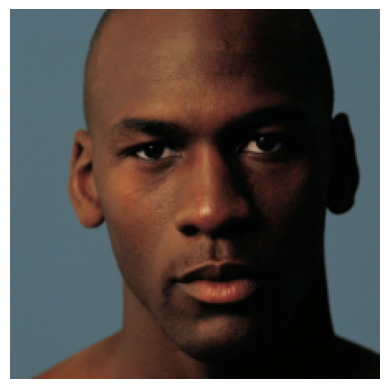

In [45]:
# Download photo
import requests

image_url = 'https://media.gq.com/photos/5ebc1032e297c603a05b2738/4:3/w_2421,h_1816,c_limit/Michael_Jordan_2007_Larry_Platt_October_2007.jpg'

img = Image.open(requests.get(url=image_url, stream=True).raw).convert('RGB')

with torch.inference_mode():
    labels = learner.model(tfms(img).unsqueeze(dim=0).to('cuda'))
    print(f"Age: {int(labels['age'].item()*100)} | Gender: {gender_class[int(labels['gender'].item())]} | Race: {race_class[labels['race'].argmax(dim=0).item()]}")
    plt.imshow(rtfms(tfms(img)))
    plt.axis(False)